In [2]:
import dataclasses
import jax
import jax.scipy as jsp
import jax.numpy as jnp
import numpy as np
from functools import partial
from typing import Callable

def jax_dataclass(cls):
    d = dataclasses.dataclass(cls, frozen=True, order=True)
    return jax.tree_util.register_dataclass(d, data_fields=['params'], meta_fields=[]) 

# STATS 607
## Week 7: Probabilistic programming and neural density estimation

## Probabilistic programming language (PPL)

> A probabilistic programming language (PPL) is a programming language or framework designed to describe probabilistic models and automate inference over them. It provides high-level constructs for defining random variables, probabilistic dependencies, and likelihood functions, making it easier to implement and test statistical models without explicitly coding complex inference algorithms.

## Example from original Stan paper

- $\theta \sim \mathrm{Beta}(1, 1)$.
- $y_i \sim \mathrm{Bernoulli}(\theta)$
- Goal: infer $\theta$. Equivalently, sample from $p(\theta \mid y)$.

```
for (n in 1:N)
  y[n] ~ bernoulli(theta);
  
data {
  int<lower=0> N; int<lower=0, upper=1> y[N];
}

parameters {
  real<lower=0, upper=1> theta; 
}

model {
  // N >= 0
  // y[n] in { 0, 1 }
  // theta in [0, 1]
  theta ~ beta(1, 1); // prior
  y ~ bernoulli(theta); // likelihood
}
```

## Options for sampling
If we want to sample from $p(\theta \mid y)$ we have a few options:
 
- Directly: not unless you are lucky :-)
- Inverse transform ($F^{-1}(U)$): univariate, requires inverting CDF.
- Rejection sampling: good for low dimensions.
- MCMC:
  - Metropolis-Hastings
  - Slice sampling
  - Gibbs sampling
  - Hamiltonian Monte-Carlo/Langevin dynamics
- VI; SVGD
  
So the fundamental thing is being able to compute $\log p(\theta, y)$ and/or its gradient.

## Let's build a PPL
Let's build a simple class structure that will enable inference.

In [2]:
@jax_dataclass
class RandomVariable:
    params: tuple
        
    def __call__(self, x):
        return x
        
    # def sample(self, key):
    #     ...
        
    def log_p(self, x):
        pass

In [18]:
import jax.scipy.stats

class Beta(RandomVariable):
    def log_p(self, x):
        a, b = self.params
        return jax.scipy.stats.beta.logpdf(x, a, b)
    
theta = Beta((1., 1.))
theta

Beta(params=(1.0, 1.0))

In [19]:
@jax_dataclass
class Bernoulli(RandomVariable):
    def log_p(self, x):
        p, = self.params
        return jnp.select(
            [x == 1, x == 0],
            [jnp.log(p), jnp.log1p(-p)],
            -jnp.inf
        )

In [20]:

@jax_dataclass
class Beta(RandomVariable):        
    def log_p(self, x):
        a, b = self.params
        return jsp.stats.beta.logpdf(x, a, b)

In [21]:
class Model:
    def __init__(self):
        self._vars = {}
    
    def add_var(self, var: RandomVariable, name: str):
        self._vars[name] = var
        
    def log_p(self, data: dict[str, float]) -> float:
        ret = 0.
        for name, var in self._vars.items():
            bound_params = ()
            for param in var.params:    
                if isinstance(param, RandomVariable):
                    value = next(
                        data[name] 
                        for name, v in self._vars.items()
                        if v is param
                    )
                    bound_params += (param(value),)
                else:
                    bound_params += (param,)
            ret += (
                dataclasses
                .replace(var, params=bound_params)
                .log_p(data[name])
            )
        return ret

            
mdl = Model()
theta = Beta((1., 1.))
mdl.add_var(theta, 'theta')
obs = Bernoulli((theta,))
mdl.add_var(obs, 'y0')
mdl.log_p({'theta': .3, 'y0': 1})

Array(-1.2039728, dtype=float32, weak_type=True)

In [22]:
p = 0.7
n = 100
data = {f'y_{i}': int(x < p) for i, x in enumerate(np.random.rand(n))}

In [23]:
mdl = Model()
theta = Beta((1., 1.))
mdl.add_var(theta, 'theta')
for i in range(100):
    mdl.add_var(Bernoulli((theta,)), f'y_{i}')

In [24]:
mdl.log_p({**data, 'theta': 0.8})

Array(-72.220924, dtype=float32, weak_type=True)

## Implementing a sampling algorithm
Let's start basic:

In [25]:
def sample_mh(
    proposal: Callable[dict[str, float], dict[str, float]],
    log_p: Callable[dict[str, float], float],
    x0: dict[str, float],
    niter: int,
    key: jax.random.PRNGKey
):
    x = x0
    lp = log_p(x)
    ret = []
    for i in range(niter):
        key, subkey1, subkey2 = jax.random.split(key, 3)
        x_prime = proposal(x, subkey1)
        lpp = log_p(x_prime)
        # min(p/p', 1)
        if jax.random.exponential(subkey2) > lp - lpp:
            x = x_prime
            lp = lpp
        ret.append(x)
    return ret

In [26]:
from jax import lax

def sample_mh_scan(
    proposal: Callable[dict[str, float], dict[str, float]],
    log_p: Callable[dict[str, float], float],
    x0: dict[str, float],
    niter: int,
    key: jax.random.PRNGKey
):
    def body(accum, _):
        (key, x, lp) = accum
        key, subkey1, subkey2 = jax.random.split(key, 3)
        x_prime = proposal(x, subkey1)
        lpp = log_p(x_prime)
        # min(p/p', 1)
        accept = jax.random.exponential(subkey2) > lp - lpp
        (x, lp) = jax.tree.map(
            lambda a, b: jnp.where(accept, a, b),
            (x_prime, lpp),
            (x, lp)
        )
        return (key, x, lp), x

    x = x0
    lp = log_p(x)

    _, xs = lax.scan(body, (key, x0, lp), length=niter)
    return xs

In [27]:
def proposal(_, key):
    return jax.random.beta(key, 1., 1.)

res = sample_mh_scan(proposal, log_p, 0.5, 100000, key)

NameError: name 'log_p' is not defined

In [28]:
import matplotlib.pyplot as plt
plt.hist(res, bins=100);

NameError: name 'res' is not defined

## Langevin dynamics

In [47]:
from jax import grad

grad(log_p)(.4)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [48]:
from jax import lax, grad

def sample_langevin(
    log_p: Callable[dict[str, float], float],
    x0: dict[str, float],
    niter: int,
    key: jax.random.PRNGKey,
    step_size: float = 0.1
):
    def body(accum, _):
        x, key = accum
        key, subkey = jax.random.split(key)
        noise = jax.random.normal(key)
        g = grad(log_p)(x)
        x = x + 0.5 * step_size * g + jnp.sqrt(step_size) * noise
        return (x, key), x
        
    _, xs = lax.scan(body, (x0, key), length=niter)
    return xs

In [49]:
res = sample_langevin(
    log_p,
    0.5,
    1000000,
    jax.random.PRNGKey(92682),
    step_size=0.001
)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [50]:
plt.hist(res[1000:][::100], bins=100);

NameError: name 'res' is not defined

## Allowing for transformations

In [51]:
class LogitBijector:
    @staticmethod
    def forward(x):
        return jax.nn.sigmoid(x)  # 1 / (1 + exp(-x))

    @staticmethod
    def backward(y):
        return jax.scipy.special.logit(y)  # log(p / (1 - p))
    
    @staticmethod
    def log_det_jac(y):
        # dx/dy
        # y = sigmoid(x)
        # x = logit(y)
        # dx/dy = 
        return y * (1 - y)  # -log(y(1-y))


In [52]:
def transform(base_cls, f):
    @jax_dataclass
    class TransformedRV(base_cls):
        def __call__(self, x):
            return f(x)
        
    return TransformedRV

In [53]:
@jax_dataclass
class Normal(RandomVariable):
    def log_p(self, x):
        mu, sigma = self.params
        return jax.scipy.stats.norm.logpdf(x, mu, sigma)

LogitNormal = transform(Normal, jax.nn.sigmoid)

In [54]:
import scipy.integrate

ln = LogitNormal((0., 1.))

ln.log_p(-100.)

scipy.integrate.quad(lambda x: jnp.exp(ln.log_p(x)), -jnp.inf, jnp.inf)

(1.00000001747772, 4.8720096375076466e-09)

In [55]:
mdl = Model()
logit_theta = LogitNormal((0., 1.))
mdl.add_var(logit_theta, 'logit_theta')
for i in range(100):
    mdl.add_var(Bernoulli((logit_theta,)), f'y_{i}')

In [56]:
def log_p(x):
    return mdl.log_p({**data, 'logit_theta': x})

res = sample_langevin(log_p, 0., 10000, key)

KeyError: 'y_0'

In [57]:
plt.hist(logit_theta(res), bins=100);

NameError: name 'res' is not defined

## Bayesian logistic regression

In [58]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/WillKoehrsen/eecs-491/master/assign/project/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [59]:
from jax import vmap

@jax_dataclass
class IsoNorm(RandomVariable):
    def log_p(self, x):
        mu, sigma = self.params
        return vmap(jax.scipy.stats.norm.logpdf)(x, mu, sigma).sum()

In [60]:
k = df.shape[1] - 1

mu = jnp.zeros(k)
sigma = jnp.ones_like(mu)

beta = IsoNorm((mu, sigma))

In [61]:
from jax.scipy.special import expit, xlogy, xlog1py


@partial(jax.tree_util.register_dataclass, data_fields=['params', 'x'], meta_fields=[])
@dataclasses.dataclass(frozen=True, order=True)
class LogisticRegression(RandomVariable):
    x: jax.Array
    
    def log_p(self, y: int) -> float:
        beta, = self.params
        mu = beta.dot(self.x)
        p = expit(mu)
        return xlogy(y, p) + xlog1py(1 - y, -p)

In [62]:
p = df.shape[1] - 1
mu = jnp.zeros(p + 1)
sigma = jnp.ones_like(mu)
beta = IsoNorm((mu, sigma))

In [63]:
mdl = Model()
mdl.add_var(beta, 'beta')
params = (beta,)
data = {}
X, y = np.split(df.to_numpy(), [-1], axis=1)
X -= X.mean(0)
X /= X.std(0)
for xi, yi in zip(X, y):
    xi = np.insert(xi, 0, 1.)  # add intercept
    name = f'y_{i}'
    mdl.add_var(LogisticRegression(params, xi), name)
    data[name] = yi

In [64]:
X.std(0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [70]:
def log_p(x):
    return mdl.log_p({**data, 'beta': x})[0]

with jax.debug_nans(True):
    res = sample_langevin(log_p, mu, 1000000, key, step_size=1e-7)

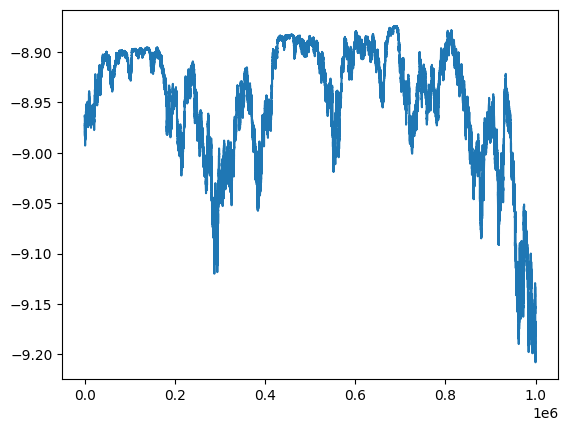

In [71]:
plt.plot(vmap(log_p)(res))

In [68]:
res

Array([[-0.01154693, -0.0115008 , -0.0115001 , ..., -0.01151687,
        -0.01151008, -0.01150014],
       [-0.00223546, -0.00214262, -0.0021412 , ..., -0.00217496,
        -0.00216129, -0.00214129],
       [ 0.00509328,  0.00523234,  0.00523446, ...,  0.00518389,
         0.00520437,  0.00523434],
       ...,
       [-1.082463  , -0.28048214, -0.2682527 , ..., -0.5598929 ,
        -0.44180244, -0.26896718],
       [-1.0938009 , -0.29182425, -0.27959487, ..., -0.5712335 ,
        -0.4531437 , -0.28030935],
       [-1.0947    , -0.29272714, -0.28049782, ..., -0.5721351 ,
        -0.45404583, -0.2812123 ]], dtype=float32)

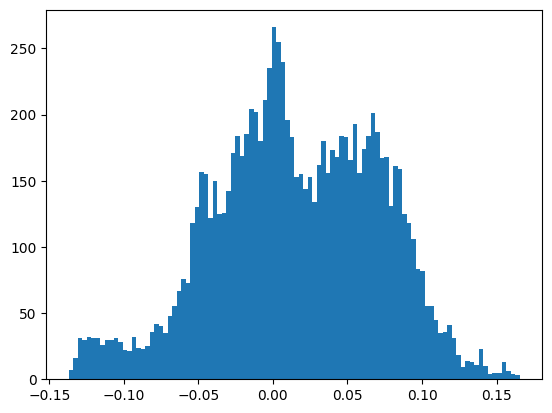

In [73]:
plt.hist(res[:, 1][1000:][::100], bins=100);

In [ ]:
import seaborn as sns
rdf = pd.DataFrame(res[10000:][::1000], columns=np.insert(df.columns[:-1], 0, "Intercept"))
sns.pairplot(rdf)

## Neural density estimation
- Goal: learn complicated/multimodal density $p(x)$ by training a neural network $\hat{p}(x;\theta)$ **and be able to sample from it**.
- Objective function:

$$\max_\theta \sum_i \log \hat{p}(x_i;\theta)$$

- Idea: Assume that $x_i \sim f(z_i)$ for some function $f$ and tractable base distribution, e.g. $z_i \sim \mathcal{N}(0, 1)$
- Thus, $p(x) = p(f^{-1}(x))|\det J|^{-1}$.

In [4]:
from typing import NamedTuple, Callable

class BaseDistr(NamedTuple):
    sample: Callable
    log_p: Callable

class DumbNDE(NamedTuple):
    base: BaseDistr
    f: Callable
    finv: Callable
    
    def sample(self, key):
        return self.f(self.base.sample(key))
    
    def log_p(self, y):
        x = self.finv(y)
        J = jnp.atleast_2d(jax.jacfwd(self.f)(x))
        _, ld = jnp.linalg.slogdet(J)
        return base.log_p(x) - ld

In [5]:
base = BaseDistr(jax.random.normal, jax.scipy.stats.norm.logpdf)
pos = DumbNDE(base, jnp.exp, jnp.log)

from scipy.integrate import quad
quad(lambda x: jnp.exp(pos.log_p(x)), 0., np.inf)

(1.0000000021877753, 1.445026581464459e-08)

In [6]:
base = BaseDistr(jax.random.normal, jax.scipy.stats.norm.logpdf)
pos = DumbNDE(base, jnp.exp, jnp.log)

(array([938.,  47.,   7.,   4.,   0.,   2.,   1.,   0.,   0.,   1.]),
 array([4.01217192e-02, 4.62706423e+00, 9.21400642e+00, 1.38009491e+01,
        1.83878918e+01, 2.29748344e+01, 2.75617771e+01, 3.21487198e+01,
        3.67356606e+01, 4.13226051e+01, 4.59095459e+01]),
 <BarContainer object of 10 artists>)

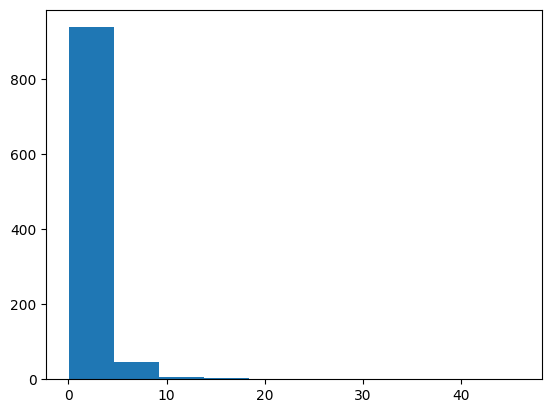

In [122]:
key = jax.random.PRNGKey(1)
plt.hist(vmap(pos.sample)(jax.random.split(key, 1000)))

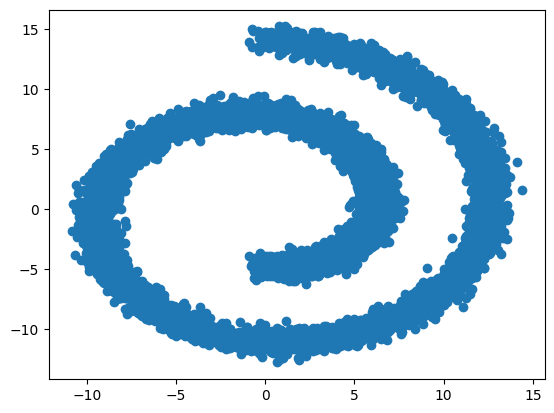

In [131]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(noise=.5, random_state=0, n_samples=10000)
plt.scatter(X[:, 0], X[:, 2])

In [132]:
base = BaseDistr(
    partial(jax.random.normal, shape=(2,)), 
    lambda x: jax.scipy.stats.norm.logpdf(x).sum()
)

## Affine Coupling Layer

Split the input $x = [x_1, x_2]$:
$$
x_2' = x_2 \cdot \exp(s(x_1)) + t(x_1)
$$
where:
- $s(x_1)$ (scale) and $t(x_1)$ (translation) are functions of $x_1$.
- $x_1$ is left unchanged: $x_1' = x_1$.



Inverse: given $x_1' = x_1$ and $x_2'$:
$$
x_2 = (x_2' - t(x_1)) \cdot \exp(-s(x_1))
$$

In [263]:
import jax.numpy as jnp
# NOTE: Equinox is like keras for jax
import equinox as eqx

class AffineCoupling(eqx.Module):
    s_net: eqx.Module
    t_net: eqx.Module
    mask: jnp.ndarray

    def __init__(self, input_size, hidden_size, mask, key):
        key1, key2 = jax.random.split(key)
        self.s_net = eqx.nn.MLP(1, 1, hidden_size, depth=2, key=key1)
        self.t_net = eqx.nn.MLP(1, 1, hidden_size, depth=2, key=key2)
        self.mask = mask

    def __call__(self, x, reverse=False):
        x1 = x[self.mask][None]
        x2 = x[1 - self.mask][None]
        s = self.s_net(x1)
        t = self.t_net(x1)
        if reverse:
            x2 = (x2 - t) * jnp.exp(-s)
        else:
            x2 = x2 * jnp.exp(s) + t
        #  jax version of if statement
        return jnp.zeros(2).at[jnp.array([self.mask, 1 - self.mask])].set([x1[0], x2[0]])

    def log_det_jacobian(self, x):
        x1 = x[self.mask]
        s = self.s_net(x1[None])
        return s

In [264]:
f = AffineCoupling(2, 16, 0, key)

a = jnp.array([1., 2.])

In [265]:
f(f(a), True)

Array([1.       , 2.0000002], dtype=float32)

In [266]:
jnp.linalg.slogdet(jax.jacrev(f)(jnp.array([1., 2.])))

SlogdetResult(sign=Array(1., dtype=float32), logabsdet=Array(0.25463378, dtype=float32))

In [267]:
f.log_det_jacobian(jnp.array([1., 2.]))

Array([0.25463372], dtype=float32)

In [283]:
class Stack(eqx.Module):
    fs: list[AffineCoupling]
        
    def __call__(self, x, reverse=False):
        l = self.fs
        if reverse:
            l = l[::-1]
        for f in l:
            x = f(x, reverse=reverse)
        return x
    
    def log_det_jacobian(self, x):
        s = 0.
        for f in self.fs:
            s += f.log_det_jacobian(x)
            x = f(x)
        return s

In [284]:
s = Stack([AffineCoupling(2, 16, 0, key), AffineCoupling(2, 16, 1, key)])

In [285]:
jnp.linalg.slogdet(jax.jacrev(s)(a))

SlogdetResult(sign=Array(1., dtype=float32), logabsdet=Array(0.7483315, dtype=float32))

In [286]:
s.log_det_jacobian(a)

Array([0.74834013], dtype=float32)

In [287]:
base2d = BaseDistr(
    sample=lambda key: jax.random.normal(key, shape=2),
    log_p=lambda x: jax.scipy.stats.norm.logpdf(x).sum()
)
nf = DumbNDE(base2d, s, partial(s.__call__, reverse=True))

In [288]:
vmap(nf.log_p)(data).mean()

Array(-26.40413, dtype=float32)

In [289]:
data = X[:, [0, 2]]

f = eqx.filter_jit(lambda b, x: vmap(b.log_p)(x).mean())
g = eqx.filter_jit(eqx.filter_grad(f))

In [291]:
nf = DumbNDE(base2d, s, partial(s.__call__, reverse=True))

for i in range(10000):
    dnf = g(nf, data)
    nf1 = eqx.apply_updates(nf, jax.tree.map(lambda x: 1e-4 * x, dnf))
    y = f(nf1, data)
    if np.isfinite(y) and i % 1000 == 0:
        nf = nf1
        print(i, y)
    else:
        break

-26.405653


In [292]:
q = vmap(nf.sample)(jax.random.split(key, 1000))

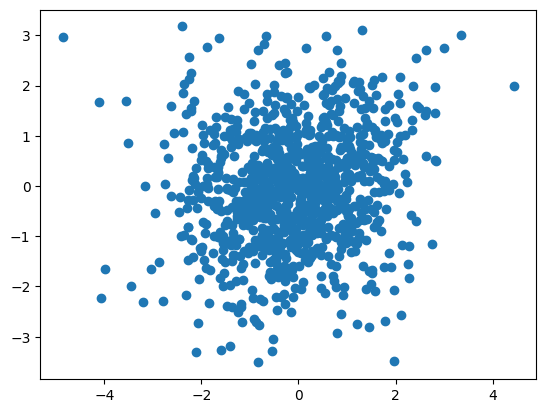

In [293]:
plt.scatter(*q.T)